### ResNet-50

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
from torch.utils.data import random_split


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
# Training hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 0.001
weight_decay = 1e-4

# CIFAR-100 has 100 classes
num_classes = 100

# Path to save model
model_save_path = './resnet50_cifar100.pth'

In [12]:
# CIFAR-100 normalization statistics
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# Define transforms for training and testing
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, 
                                  download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False,
                                download=True, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)

# Get class names
class_names = train_dataset.classes
print(f"Dataset loaded: {len(train_dataset)} training samples, {len(test_dataset)} test samples")

Files already downloaded and verified
Files already downloaded and verified
Dataset loaded: 50000 training samples, 10000 test samples


In [13]:
def get_resnet50_model(num_classes=100):
    # Load the pretrained ResNet-50 model
    model = models.resnet50(weights='IMAGENET1K_V1')
    
    # Replace the final fully connected layer to match CIFAR-100's 100 classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    return model

# Initialize the model
model = get_resnet50_model(num_classes)
model = model.to(device)

# Verify model can handle CIFAR-100 image size
test_input = torch.randn(2, 3, 32, 32).to(device)
test_output = model(test_input)
print(f"Output shape: {test_output.shape}, expected: torch.Size([2, 100])")

# Display model summary
print(model)

Output shape: torch.Size([2, 100]), expected: torch.Size([2, 100])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Seque

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [15]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            loader = dataloaders['train'] if phase == 'train' else dataloaders['val']
            dataset_size = len(dataloaders['train'].dataset) if phase == 'train' else len(dataloaders['val'].dataset)
            
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Adjust learning rate based on validation loss
                scheduler.step(epoch_loss)
                
                # Deep copy the model if it's the best
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [16]:

# Set aside 10% of training data for validation
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

# Randomly split the dataset
train_subset, val_subset = random_split(
    train_dataset, [train_size, val_size], 
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders for the subsets
train_loader = DataLoader(train_subset, batch_size=batch_size, 
                          shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size,
                        shuffle=False, num_workers=4, pin_memory=True)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

print(f"Training set: {len(train_subset)} samples")
print(f"Validation set: {len(val_subset)} samples")
print(f"Test set: {len(test_dataset)} samples")

Training set: 45000 samples
Validation set: 5000 samples
Test set: 10000 samples


In [17]:
# Train the model
model, history = train_model(
    model, 
    dataloaders, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=num_epochs
)

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/20
----------
train Loss: 3.1890 Acc: 0.2272
val Loss: 2.9562 Acc: 0.2870

Epoch 2/20
----------
train Loss: 2.6326 Acc: 0.3314
val Loss: 2.8434 Acc: 0.3144

Epoch 3/20
----------
train Loss: 2.2619 Acc: 0.4032
val Loss: 2.4829 Acc: 0.3792

Epoch 4/20
----------
train Loss: 1.9840 Acc: 0.4607
val Loss: 2.0741 Acc: 0.4510

Epoch 5/20
----------
train Loss: 1.8233 Acc: 0.4975
val Loss: 1.9249 Acc: 0.4808

Epoch 6/20
----------
train Loss: 1.7919 Acc: 0.5033
val Loss: 1.8970 Acc: 0.4774

Epoch 7/20
----------
train Loss: 1.6188 Acc: 0.5422
val Loss: 2.5115 Acc: 0.4700

Epoch 8/20
----------
train Loss: 1.6104 Acc: 0.5460
val Loss: 1.8117 Acc: 0.5098

Epoch 9/20
----------
train Loss: 1.5275 Acc: 0.5649
val Loss: 1.7546 Acc: 0.5160

Epoch 10/20
----------
train Loss: 1.4365 Acc: 0.5845
val Loss: 1.9245 Acc: 0.5050

Epoch 11/20
----------
train Loss: 1.3845 Acc: 0.6005
val Loss: 1.7520 Acc: 0.5212

Epoch 12/20
----------
train Loss: 1.3290 Acc: 0.6126
val Loss: 1.7208 Acc: 0.5332

E

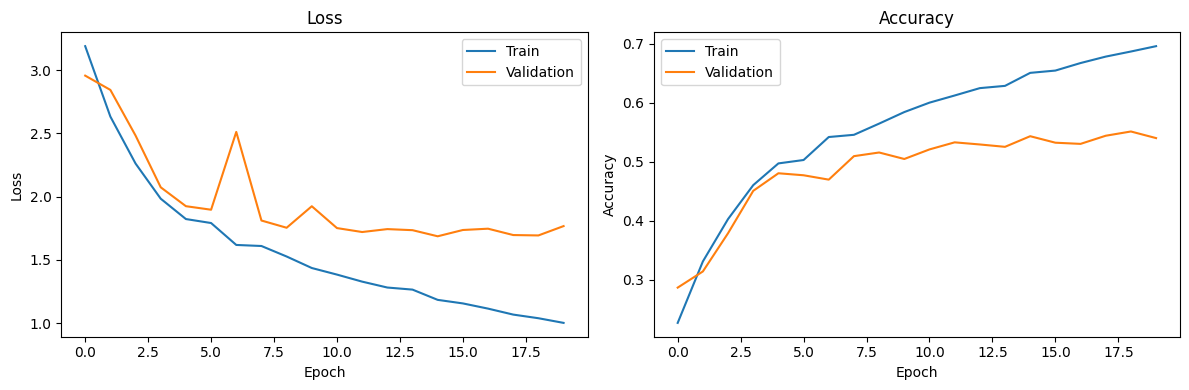

In [18]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Collect all predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    dataset_size = len(dataloader.dataset)
    test_loss = running_loss / dataset_size
    test_acc = running_corrects.double() / dataset_size
    
    print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')
    
    return test_loss, test_acc, all_preds, all_labels

# Evaluate on the test set
test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion)

Test Loss: 1.6484 Test Acc: 0.5685


In [21]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, output_dict=True)

# Create a DataFrame from the metrics
rows = []
for cls_str, vals in report.items():
    if cls_str.isdigit():
        i = int(cls_str)
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        rows.append({
            'class': i,
            'class_name': class_names[i] if i < len(class_names) else f"Class {i}",
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'TN': tn,
            'Precision': vals['precision'],
            'Recall': vals['recall'],
            'F1-score': vals['f1-score']
        })

df_metrics = pd.DataFrame(rows).sort_values('class').reset_index(drop=True)
print(df_metrics.head(10))  # Show first 10 classes

# Overall Accuracy
overall_acc = np.trace(cm) / cm.sum()
print(f"\nOverall Test Accuracy: {overall_acc:.4f}")

   class     class_name  TP  FP  FN    TN  Precision  Recall  F1-score
0      0          apple  76  18  24  9882   0.808511    0.76  0.783505
1      1  aquarium_fish  67  23  33  9877   0.744444    0.67  0.705263
2      2           baby  35  17  65  9883   0.673077    0.35  0.460526
3      3           bear  31  43  69  9857   0.418919    0.31  0.356322
4      4         beaver  33  82  67  9818   0.286957    0.33  0.306977
5      5            bed  77  80  23  9820   0.490446    0.77  0.599222
6      6            bee  62  39  38  9861   0.613861    0.62  0.616915
7      7         beetle  52  35  48  9865   0.597701    0.52  0.556150
8      8        bicycle  62  15  38  9885   0.805195    0.62  0.700565
9      9         bottle  62  16  38  9884   0.794872    0.62  0.696629

Overall Test Accuracy: 0.5685


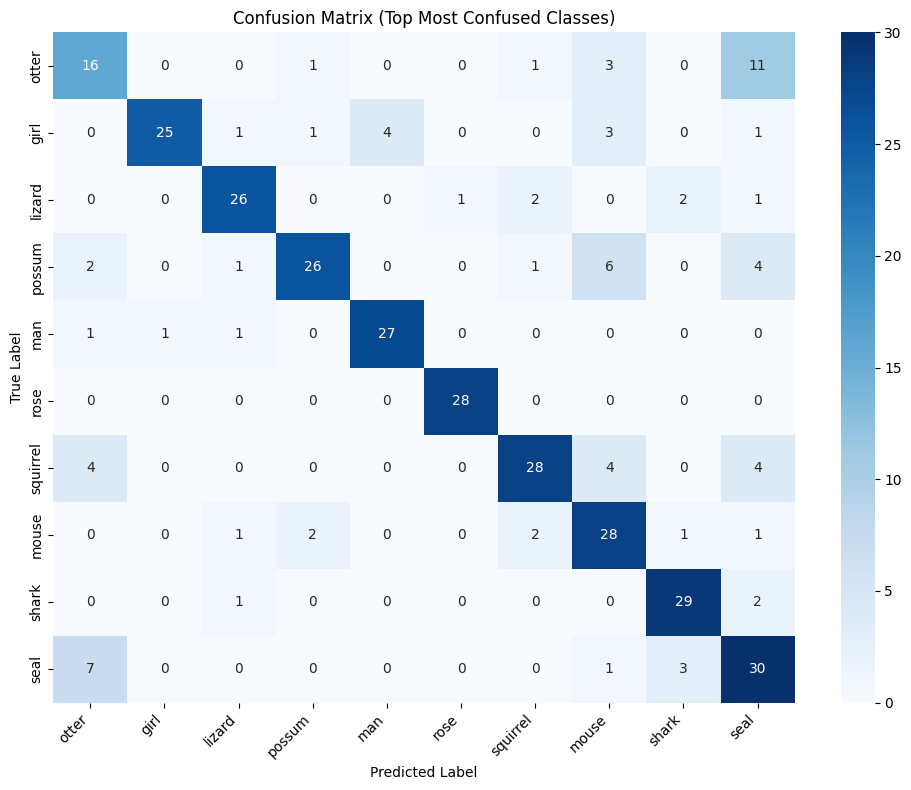

In [22]:
# Plot confusion matrix for top classes (too many classes to show all 100)
plt.figure(figsize=(10, 8))
top_n_classes = 10  # Show top 10 classes

# Get indices of the most confused classes
class_accuracies = [cm[i,i]/cm[i,:].sum() for i in range(len(cm))]
indices = np.argsort(class_accuracies)[:top_n_classes]  # Get indices of lowest accuracy classes

# Create a subset of the confusion matrix
cm_subset = cm[np.ix_(indices, indices)]
class_names_subset = [class_names[i] for i in indices]

# Plot
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_subset, yticklabels=class_names_subset)
plt.title('Confusion Matrix (Top Most Confused Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

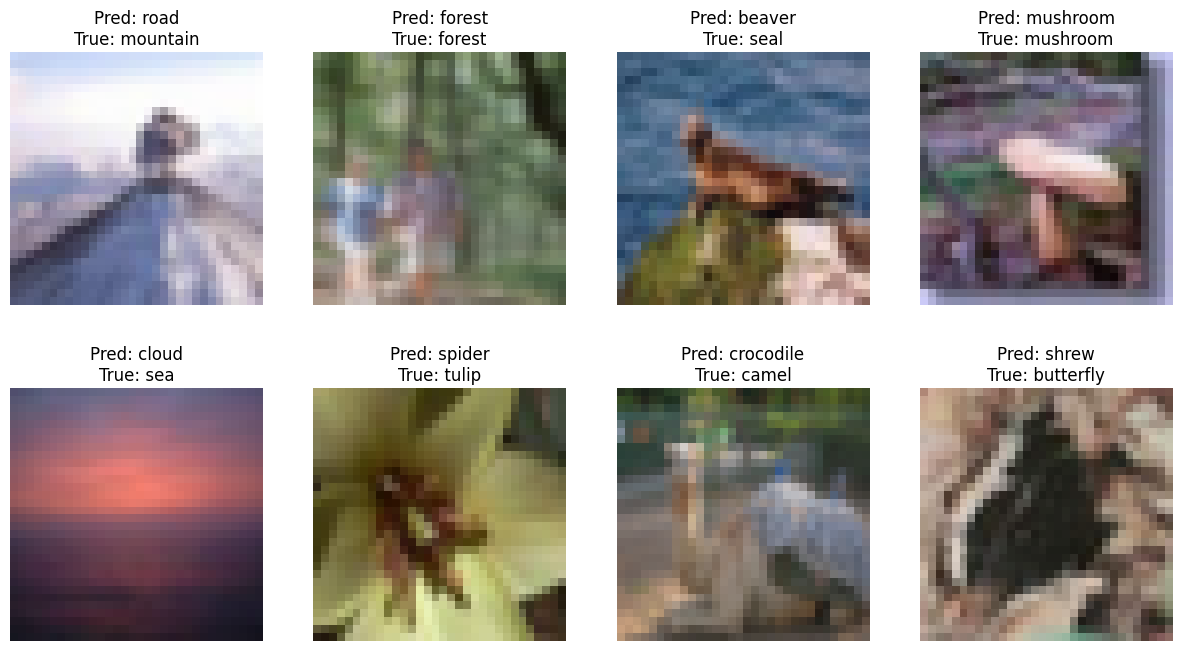

In [23]:
# Display some example predictions
def show_predictions(model, dataloader, class_names, num_images=8):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 8))
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    return
                
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')
                
                # Convert image for display
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                # Denormalize
                img = img * np.array(cifar100_std) + np.array(cifar100_mean)
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
    
    plt.tight_layout()
    plt.show()

# Show sample predictions
show_predictions(model, test_loader, class_names, num_images=8)